# Data Preprocessing

This notebook will look at steps for preprocessing data before it is given to a machine learning model. It will cover: 
1. [Categorical vs Continous Data](#Categorical-vs-Continous-Data)

2. [Dealing with Missing Data + Bounding Data](#Missing-Data-+-Bounding-Data)

3. [Scaling](#Scaling)

4. [Encoding](#Encoding)

5. [Combining Preprocessing](#Combining-Preprocessing)

6. [Feature Importance](#Feature-Importance)

7. [Feature Selection](#Feature-Selection)

8. [Summary](#Summary)

In [38]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

## Categorical vs Continous Data

Categorical data is data that falls into different classes or categories, eg. Nationality, whereas Numerical or Continous data is represented by numbers and is quantitative, such as age or height.

In [39]:
adult_census = pd.read_csv("datasets/adult-census.csv")

# drop the duplicated column `"education-num"` as stated in the first notebook
adult_census = adult_census.drop(columns="education-num")
adult_census.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [40]:
# check the datatype for each column
adult_census.dtypes

age                int64
workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

In [41]:
# split data and target columns
data, target = adult_census.drop(columns="class"), adult_census["class"]

Selection of Categorical and Numerical data can be __automated__:

In [42]:
from sklearn.compose import make_column_selector

# Split by type
numerical_columns_selector = make_column_selector(dtype_exclude=object)
categorical_columns_selector = make_column_selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

#categorical_columns
numerical_columns

['age', 'capital-gain', 'capital-loss', 'hours-per-week']

## Missing Data + Bounding Data

Often columns in datasets can contain misssing values, or require an upper and/or lower limit to be set on the values.

## Scaling

In [43]:
# first split the data so we can evaluate the models used
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data[numerical_columns], target, random_state=42)

In [44]:
data_train.describe()

,age,capital-gain,capital-loss,hours-per-week
count,36631.000000,36631.000000,36631.000000,36631.000000
mean,38.642352,1087.077721,89.665311,40.431247
std,13.725748,7522.692939,407.110175,12.423952
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


As we can see, there is a wide range of means and standard deviations across the features, meaning that some models will beneift from the features being __scaled__ first.

<u>SCALING</u>: Here are some reasons for scaling features:

- Models that rely on the distance between a pair of samples, for instance k-nearest neighbors, should be trained on normalized features to make each feature contribute approximately __equally__ to the distance computations.

- Many models such as logistic regression use a numerical solver (based on gradient descent) to find their optimal parameters. This solver converges __faster__ when the features are scaled.

Whether or not a machine learning model requires scaling the features depends on the model family. Linear models such as logistic regression generally benefit from scaling the features while other models such as decision trees do not need such preprocessing (but will not suffer from it).

We show how to apply such normalization using a scikit-learn transformer called StandardScaler. This transformer shifts and scales each feature individually so that they all have a __0-mean__ and a __unit standard deviation__.

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler

StandardScaler()

As with predictors, where we need to `.fit` and then `.predict` from the data, with a transformer we must also call the `.fit` method and then the `.transform` method. Here we can combine that into one step:

In [46]:
# call the fit_transform method to fit then transform the data matrix provided to the transformer
data_train_scaled = scaler.fit_transform(data_train)

# put the resulting array into a Dataframe with the same column names as before
data_train_scaled = pd.DataFrame(data_train_scaled,
                                 columns=data_train.columns)
data_train_scaled.describe()

,age,capital-gain,capital-loss,hours-per-week
count,3.663100e+04,3.663100e+04,3.663100e+04,3.663100e+04
mean,-1.263553e-16,-1.708425e-15,-1.652358e-15,1.146502e-16
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.576792e+00,-1.445084e-01,-2.202513e-01,-3.173852e+00
25%,-7.753674e-01,-1.445084e-01,-2.202513e-01,-3.471139e-02
50%,-1.196565e-01,-1.445084e-01,-2.202513e-01,-3.471139e-02
75%,6.817680e-01,-1.445084e-01,-2.202513e-01,3.677425e-01
max,3.741752e+00,1.314865e+01,1.047970e+01,4.714245e+00


Notice that the mean of all the columns is close to 0 and the standard deviation in all cases is close to 1. Furthermore StandardScaler does not change the structure of the data itself but the axes get shifted and scaled.

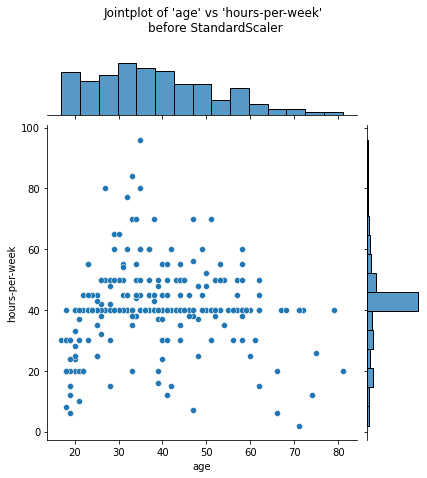

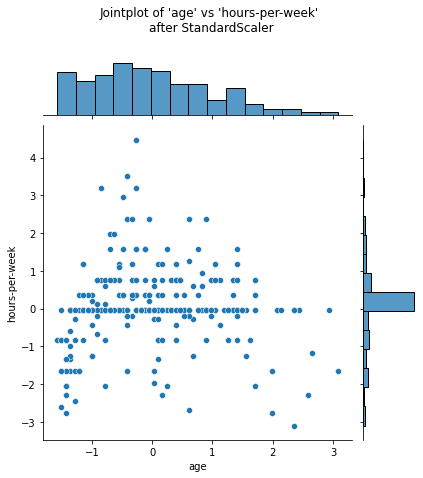

In [47]:
# reduce number of points to visualize to have a clearer plot to the first 300
num_points_to_plot = 300

# plot unscaled data
sns.jointplot(data=data_train[:num_points_to_plot], x="age",
              y="hours-per-week", marginal_kws=dict(bins=15))
plt.suptitle("Jointplot of 'age' vs 'hours-per-week' \nbefore StandardScaler", y=1.1)

# plot scaled data
sns.jointplot(data=data_train_scaled[:num_points_to_plot], x="age",
              y="hours-per-week", marginal_kws=dict(bins=15))
_ = plt.suptitle("Jointplot of 'age' vs 'hours-per-week' \nafter StandardScaler", y=1.1)

We can add this Scaler to a model pipeline, to demonstrate the benefit of using it. Note that the pipeline will have the same methods as the final predictor: `fit` and `predict` (and additionally `predict_proba`, `decision_function`, or `score`).

In [48]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [49]:
# time the fitting of the data
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [50]:
model_name = model.__class__.__name__
score = model.score(data_test, target_test)
print(f"The accuracy using a scaled {model_name} is {score:.3f} "
      f"with a fitting time of {elapsed_time:.3f} seconds "
      f"in {model[-1].n_iter_[0]} iterations")

The accuracy using a scaled Pipeline is 0.807 with a fitting time of 0.107 seconds in 12 iterations


In [51]:
# create a baseline for comparison
model = LogisticRegression()
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [52]:
model_name = model.__class__.__name__
score = model.score(data_test, target_test)
print(f"The accuracy using an unscaled {model_name} is {score:.3f} "
      f"with a fitting time of {elapsed_time:.3f} seconds "
      f"in {model.n_iter_[0]} iterations")

The accuracy using an unscaled LogisticRegression is 0.807 with a fitting time of 0.280 seconds in 59 iterations


We can see that the computation time is much reduced when using the Scaler.

## Encoding

Here we will discuss how to deal with categorical features through encoding (to allow linear models to deal with the non-continous data), specifically looking at [__ordinal encoding__](#Encoding-Ordinal-Categories), where order matters, and [__one-hot encoding__](#Encoding-Nominal-Categories), where order does not matter. This is important as Linear models will be impacted by misordered categories while tree-based models will not. 

In [53]:
data_categorical = data[categorical_columns]
data_categorical.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States


In [54]:
print(f"The dataset is composed of {data_categorical.shape[1]} features")

The dataset is composed of 8 features


### Encoding Ordinal Categories

Here we will encode each category within a feature with a different number. 

In [55]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(data_categorical)

In [56]:
# put the resulting array into a Dataframe with the same column names as before
data_encoded = pd.DataFrame(data_encoded,
                                 columns=data_categorical.columns)
data_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,4.0,1.0,4.0,7.0,3.0,2.0,1.0,39.0
1,4.0,11.0,2.0,5.0,0.0,4.0,1.0,39.0
2,2.0,7.0,2.0,11.0,0.0,4.0,1.0,39.0
3,4.0,15.0,2.0,7.0,0.0,2.0,1.0,39.0
4,0.0,15.0,4.0,0.0,3.0,4.0,0.0,39.0


In [57]:
print(
    f"The dataset encoded contains {data_encoded.shape[1]} features")

The dataset encoded contains 8 features


We see that the categories have been encoded for each feature (column) independently. We also note that the __number of features__ before and after the encoding is the __same__.

However, be careful when applying this encoding strategy: using this integer representation leads downstream predictive models to assume that the values are __ordered__ (0 < 1 < 2 < 3… for instance).

By default, `OrdinalEncoder` uses a lexicographical strategy to map string category labels to integers. This strategy is arbitrary and often meaningless. For instance, suppose the dataset has a categorical variable named `"size"` with categories such as “S”, “M”, “L”, “XL”. We would like the integer representation to respect the meaning of the sizes by mapping them to increasing integers such as 0, 1, 2, 3. However, the lexicographical strategy used by default would map the labels “S”, “M”, “L”, “XL” to 2, 1, 0, 3, by following the __alphabetical order__.

The `OrdinalEncoder` class accepts a categories constructor argument to pass categories in the expected ordering explicitly. 

### Encoding Nominal Categories

`OneHotEncoder` is an alternative encoder that __prevents the downstream models to make a false assumption about the ordering__ of categories. For a given feature, it will create as many new columns as there are possible categories. For a given sample, the value of the column corresponding to the category will be set to 1 while all the columns of the other categories will be set to 0.

Note that when splitting data into test and train sets, it may occur that rare categories do not end up in both, so it is good to specify `handle_unknown="ignore"`, so that if unknown categories are encountered during transform, no error will be raised but the resulting one-hot encoded columns for this feature will be all zeros

In [58]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
encoder

OneHotEncoder(handle_unknown='ignore', sparse=False)

As we can see, each category (unique value) became a column; the encoding returned, for each sample, a 1 to specify which category it belongs to.

In [59]:
# fit and transform the data
data_encoded = encoder.fit_transform(data_categorical)

# extract column names
columns_encoded = encoder.get_feature_names_out(data_categorical.columns)

# combine to a Dataframe
pd.DataFrame(data_encoded, columns=columns_encoded).head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
print(
    f"The encoded dataset contains {data_encoded.shape[1]} features")

The encoded dataset contains 102 features


### Comparison of Encoding methods

In [61]:
# example using Ordinal Encoding
model = make_pipeline(
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    LogisticRegression(max_iter=500))

In [62]:
# evaluate model
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data_categorical, target)

scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.755 +/- 0.002


In [67]:
# compare to baseline Dummy Classifier which just predicts the most frequent class, ignoring the input data
from sklearn.dummy import DummyClassifier

cv_results = cross_validate(DummyClassifier(strategy="most_frequent"),
                            data_categorical, target)
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.761 +/- 0.000


In [64]:
# compare to model using One Hot Encoding
model = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=500))

# evaluate model
cv_results = cross_validate(model, data_categorical, target)
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.833 +/- 0.002


With the linear classifier chosen, using an encoding that does __not assume any ordering lead to much better result__; linear models and OrdinalEncoder are used together __only__ for ordinal categorical features, i.e. features that have a specific ordering. Otherwise, the model will underperform.

## Combining Preprocessing

In [75]:
# as mentioned before we can automate the selection of numerical and categorical columns
from sklearn.compose import make_column_selector

# Split columns by data type
numerical_columns_selector = make_column_selector(dtype_exclude=object)
categorical_columns_selector = make_column_selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [70]:
# make the transformers
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [72]:
# combine the two preproccessors
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])
    # (name, transformer, list of columns to be transformed)
    # can use remainder='passthrough' if only transforming one set of features

In [73]:
model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [74]:
# evaluate model
cv_results = cross_validate(model, data, target)
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.851 +/- 0.003


## Feature Importance

## Feature Selection

## Summary

- Numerical Features can be __scaled__ to reduce computation time.
- Categorical features should be __encoded__ if to be used by a linear model, and __one-hot encoded__ if the order does not matter.
- __One-hot encoding__ should not be used with tree-based models as it significantly increases the number of features and thus the computation time.